In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ramazanfratakda","key":"ed1566cc15f2c7491d66fcf38a8f266b"}'}

In [ ]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d undersc0re/fake-vs-real-face-classification
!unzip fake-vs-real-face-classification.zip

Dataset URL: https://www.kaggle.com/datasets/undersc0re/fake-vs-real-face-classification
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 214M/215M [00:13<00:00, 17.8MB/s]
100% 215M/215M [00:13<00:00, 16.9MB/s]
Archive:  fake-vs-real-face-classification.zip
  inflating: Validation/fake/532.jpg  
  inflating: Validation/fake/533.jpg  
  inflating: Validation/fake/534.jpg  
  inflating: Validation/fake/535.jpg  
  inflating: Validation/fake/536.jpg  
  inflating: Validation/fake/537.jpg  
  inflating: Validation/fake/538.jpg  
  inflating: Validation/fake/539.jpg  
  inflating: Validation/fake/540.jpg  
  inflating: Validation/fake/541.jpg  
  inflating: Validation/fake/542.jpg  
  inflating: Validation/fake/543.jpg  
  inflating: Validation/fake/544.jpg  
  inflating: Validation/fake/545.jpg  
  inflating: Validation/fake/546.jpg  
  inflating: Validation/fake/547.jpg  
  inflating: Validation/fake/548.jpg  
  inflating: Validation/fake/549.jpg  
  inflating: Validation/fake/5

# Kütüphanelerin eklenmesi

In [ ]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from glob import glob

from tensorflow import keras
from keras import layers
from keras.models import Sequential

# Resimleri İçe Aktarma

In [ ]:
def load_images_from_folder(path):
    images = []
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path,filename))
        if img is not None:
            images.append(img)
    return images

train_path = "/content/train"
val_path = "/content/Validation"


real_images = load_images_from_folder(os.path.join(train_path,"real"))
real_images += load_images_from_folder(os.path.join(val_path,"real"))


fake_images = load_images_from_folder(os.path.join(train_path,"fake"))
fake_images += load_images_from_folder(os.path.join(val_path,"fake"))




In [ ]:
"""plt.imshow(images[10])
plt.axis("off")
plt.show()"""

for i in range(10):
  plt.imshow(real_images[i])
  plt.axis("off")
  plt.show()





In [ ]:
print("real images :",len(real_images))
print("fake images :",len(fake_images))

real images : 949
fake images : 760


# Resimleri Önişleme

In [ ]:
def preprocess_images(images):
  preprocessed_images = []
  for image in images:
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image/255.0
    preprocessed_images.append(image)
  return preprocessed_images

real_im_processed = preprocess_images(real_images)
fake_im_processed = preprocess_images(fake_images)

In [ ]:
for i in range(10):
  plt.imshow(real_im_processed[i])
  plt.axis("off")
  plt.show()

for i in range(10):
  plt.imshow(fake_im_processed[i])
  plt.axis("off")
  plt.show()

In [ ]:



real_labels = [1] * len(real_im_processed)
fake_labels = [0] * len(fake_im_processed)

# Tüm görüntüleri ve etiketleri
all_images = np.concatenate((real_im_processed, fake_im_processed), axis=0)
all_labels = real_labels + fake_labels



In [ ]:
print("all_images :",len(all_images))
print("all_labels :",len(all_labels))

all_images : 1709
all_labels : 1709


# Verileri Train Test ve Validation Olarak Ayırma

In [ ]:
from sklearn.model_selection import train_test_split

# train ve test
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42);

# train ve validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42);


X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [ ]:
print("train :",len(X_train))
print("validation :",len(X_val))
print("test :",len(X_test))

train : 1093
validation : 274
test : 342


# Train verilerini çoğaltma

In [ ]:
data_augmentation = keras.Sequential(
    [
       keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(224, 224, 3)),
        keras.layers.experimental.preprocessing.RandomRotation(0.1),
        keras.layers.experimental.preprocessing.RandomZoom(0.1),
        keras.layers.experimental.preprocessing.RandomContrast(factor=0.2),
    ]
)


In [ ]:

augmented_images = []  # Artırılmış görüntülerin depolanacağı liste
augmented_labels = []  # Artırılmış labelların depolanacağı liste

for image, label in zip(X_train, y_train):
    for i in range(2):
      augmented_image = data_augmentation(np.expand_dims(image, 0), training=True)
      augmented_images.append(np.squeeze(augmented_image))
      augmented_labels.append(label)

# Artırılmış görüntüler ve etiketler
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

print("augmented_images :",len(augmented_images))
print("augmented_labels :",len(augmented_labels))
#augmented_images = np.array(augmented_images)



augmented_images : 2186
augmented_labels : 2186


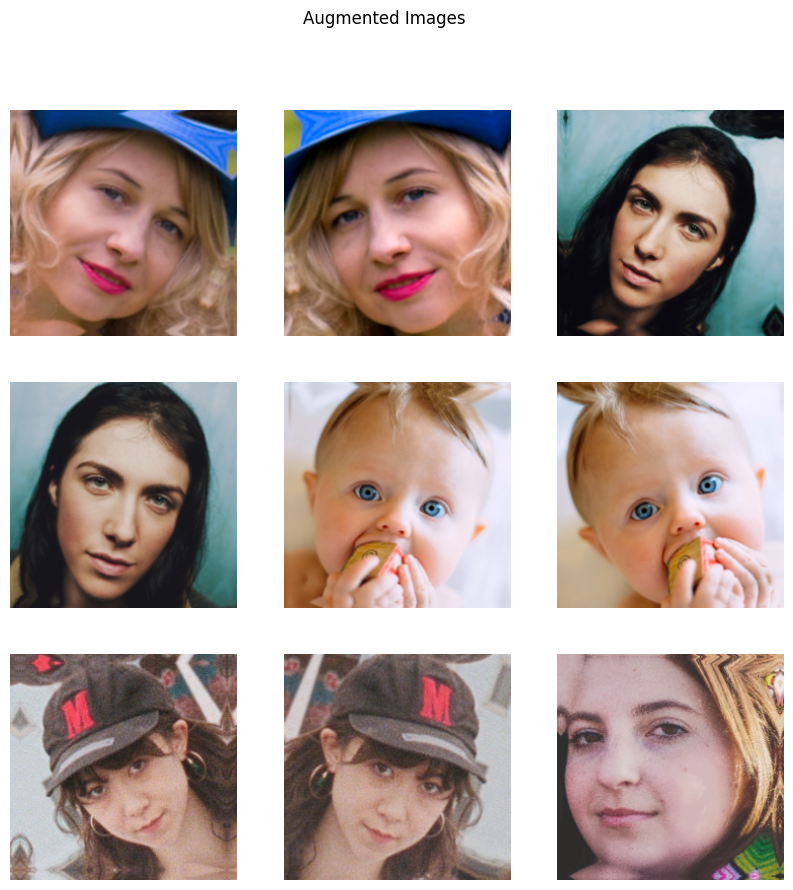

In [ ]:

# Artırılmış görüntüyü görselleştirin
import matplotlib.pyplot as plt

def show_image_grid(images, title):
    plt.figure(figsize=(10, 10))
    for i in range(min(len(images), 9)):  # İlk 9 resmi göstermek için
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


show_image_grid(augmented_images, "Augmented Images")





# MODEL OLUŞTURMA

MobilenetV3Small

In [ ]:
mobilenet_small = keras.applications.MobileNetV3Small(
    input_shape=(224, 224,3 ),
   alpha=1.0,
    minimalistic=False,
    include_top=False,
    weights="imagenet",
    dropout_rate=0.5,
    input_tensor=None,
    pooling=None,
    include_preprocessing=False,
)


mobilenet_small.summary()

4334752/4334752 [==============================] - 2s 0us/step
Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['input_1[0][0]']             
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                                        
                                                                                                  
 tf.__operators__.ad

In [ ]:
small_model = keras.Sequential()
small_model.add(mobilenet_small)
small_model.add(keras.layers.Flatten())
small_model.add(keras.layers.Dense(64, activation='relu'))
small_model.add(keras.layers.Dropout(0.5))
small_model.add(keras.layers.Dense(1, activation='sigmoid'))

small_model.trainable = False

small_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 28224)             0         
                                                                 
 dense (Dense)               (None, 64)                1806400   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2745585 (10.47 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 2745585 (10.47 MB)
______________

In [ ]:

optimizer = keras.optimizers.Adam(learning_rate=0.0001)

small_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


small_history = small_model.fit(augmented_images, augmented_labels, batch_size=32, epochs=50, validation_data=(X_val, y_val))

test_loss, test_accuracy = small_model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Epoch 1/50
69/69 [==============================] - 11s 67ms/step - loss: 1.2094 - accuracy: 0.5027 - val_loss: 0.9400 - val_accuracy: 0.4818
Epoch 2/50
69/69 [==============================] - 2s 23ms/step - loss: 1.2093 - accuracy: 0.5014 - val_loss: 0.9400 - val_accuracy: 0.4818
Epoch 3/50
69/69 [==============================] - 2s 23ms/step - loss: 1.2098 - accuracy: 0.5037 - val_loss: 0.9400 - val_accuracy: 0.4818
Epoch 4/50
69/69 [==============================] - 2s 23ms/step - loss: 1.1564 - accuracy: 0.5124 - val_loss: 0.9400 - val_accuracy: 0.4818
Epoch 5/50
69/69 [==============================] - 2s 24ms/step - loss: 1.1795 - accuracy: 0.5229 - val_loss: 0.9400 - val_accuracy: 0.4818
Epoch 6/50
69/69 [==============================] - 2s 23ms/step - loss: 1.1798 - accuracy: 0.5142 - val_loss: 0.9400 - val_accuracy: 0.4818
Epoch 7/50
69/69 [==============================] - 2s 23ms/step - loss: 1.2410 - accuracy: 0.5064 - val_loss: 0.9400 - val_accuracy: 0.4818
Epoch 8/50
6

small değerlendirme

11/11 [==============================] - 0s 23ms/step - loss: 1.1901 - accuracy: 0.7222
Test Loss: 1.190131425857544
Test Accuracy: 0.7222222089767456
11/11 [==============================] - 1s 19ms/step


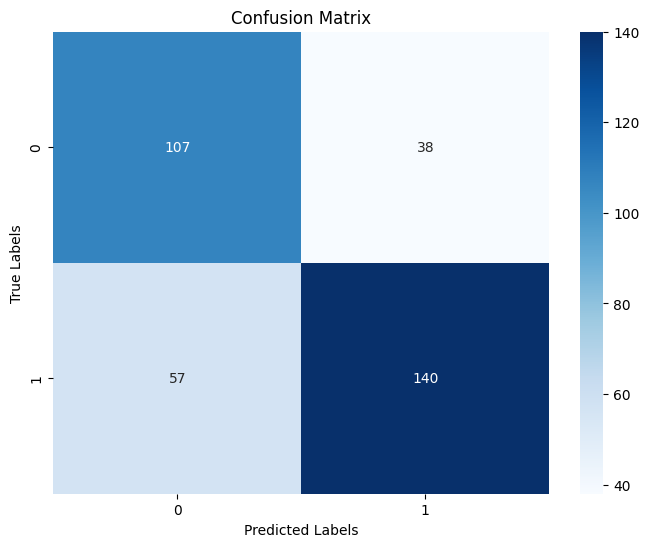

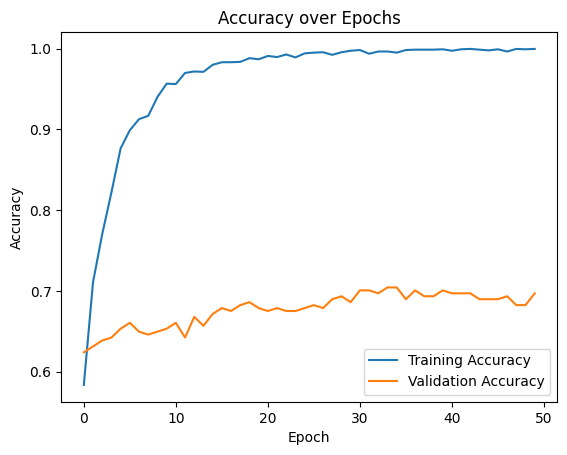

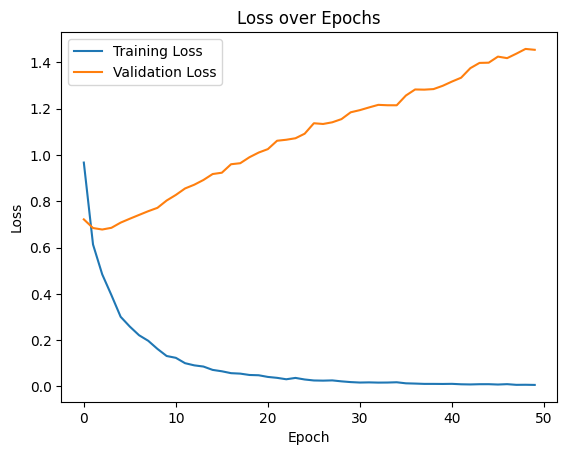

In [ ]:
test_loss, test_accuracy = small_model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Modelin tahminlerini al
y_pred = small_model.predict(X_test)
y_pred = (y_pred > 0.5)  # Sınıfları binary hale getir

# Confusion Matrix'i hesapla
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix'i görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# large Modeli eğitirken history almamışız
# Accuracy grafiğini çizdir
plt.plot(small_history.history['accuracy'], label='Training Accuracy')
plt.plot(small_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

# Loss grafiğini çizdir
plt.plot(small_history.history['loss'], label='Training Loss')
plt.plot(small_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Modeli kaydetmek
small_model.save('/content/gdrive/My Drive/small_model_2.h5')

Mounted at /content/gdrive


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Mobilenet Large

In [ ]:
mobilenet_large = keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    alpha=1.0,
    minimalistic=False,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    dropout_rate=0.2,
    pooling=None,
    classes=2,  # Sınıf sayısı
    classifier_activation='sigmoid'
)

for layer in mobilenet_large.layers[:250]:
    layer.trainable = False

mobilenet_large.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_4[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                         

In [ ]:
large_model = keras.Sequential()
large_model.add(mobilenet_large)
large_model.add(keras.layers.Flatten())
large_model.add(keras.layers.Dropout(0.1))
large_model.add(keras.layers.Dense(1, activation='sigmoid'))



large_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 47040)             0         
                                                                 
 dropout_3 (Dropout)         (None, 47040)             0         
                                                                 
 dense_6 (Dense)             (None, 1)                 47041     
                                                                 
Total params: 3043393 (11.61 MB)
Trainable params: 356481 (1.36 MB)
Non-trainable params: 2686912 (10.25 MB)
_________________________________________________________________


In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.00001)

large_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


large_history = large_model.fit(augmented_images, augmented_labels, batch_size=32, epochs=50, validation_data=(X_val, y_val))

test_loss, test_accuracy = large_model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Epoch 1/50
69/69 [==============================] - 9s 63ms/step - loss: 0.9236 - accuracy: 0.4977 - val_loss: 0.9124 - val_accuracy: 0.5182
Epoch 2/50
69/69 [==============================] - 3s 44ms/step - loss: 0.8224 - accuracy: 0.5288 - val_loss: 0.8435 - val_accuracy: 0.5182
Epoch 3/50
69/69 [==============================] - 3s 45ms/step - loss: 0.7911 - accuracy: 0.5366 - val_loss: 0.8039 - val_accuracy: 0.5182
Epoch 4/50
69/69 [==============================] - 3s 45ms/step - loss: 0.7874 - accuracy: 0.5284 - val_loss: 0.7686 - val_accuracy: 0.5182
Epoch 5/50
69/69 [==============================] - 3s 45ms/step - loss: 0.7596 - accuracy: 0.5549 - val_loss: 0.7326 - val_accuracy: 0.5146
Epoch 6/50
69/69 [==============================] - 3s 44ms/step - loss: 0.7418 - accuracy: 0.5672 - val_loss: 0.7248 - val_accuracy: 0.5182
Epoch 7/50
69/69 [==============================] - 3s 45ms/step - loss: 0.7218 - accuracy: 0.5723 - val_loss: 0.7110 - val_accuracy: 0.5219
Epoch 8/50
69

11/11 [==============================] - 0s 40ms/step - loss: 0.8313 - accuracy: 0.4269
Test Loss: 0.8312756419181824
Test Accuracy: 0.42690059542655945
11/11 [==============================] - 1s 35ms/step


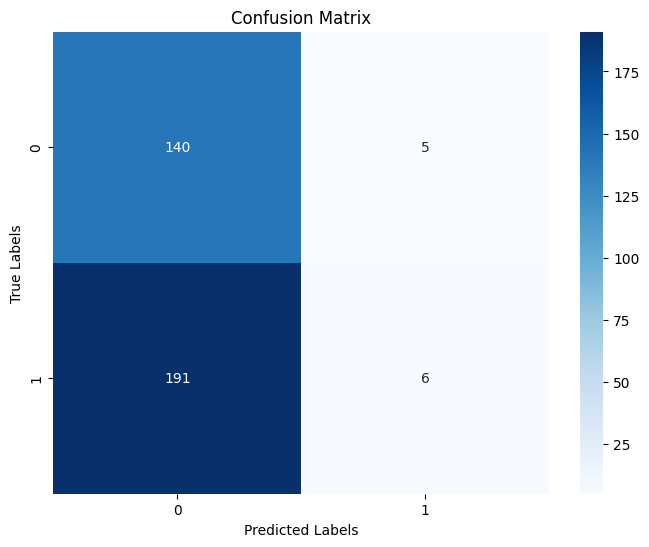

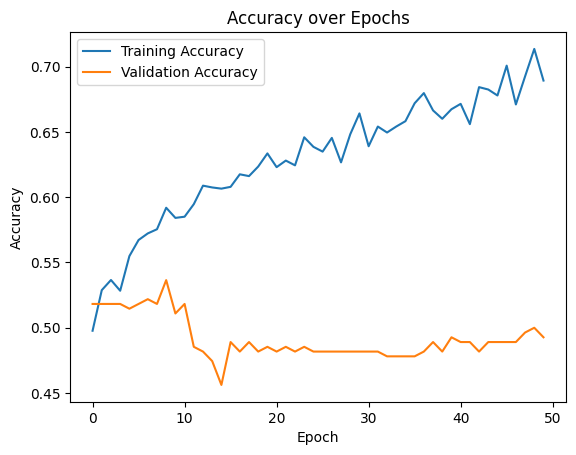

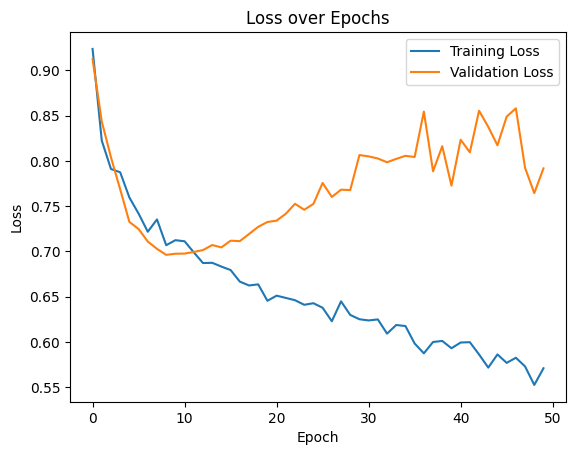

In [ ]:
test_loss, test_accuracy = large_model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Modelin tahminlerini al
y_pred = large_model.predict(X_test)
y_pred = (y_pred > 0.5)  # Sınıfları binary hale getir

# Confusion Matrix'i hesapla
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix'i görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# large Modeli eğitirken history almamışız
# Accuracy grafiğini çizdir
plt.plot(large_history.history['accuracy'], label='Training Accuracy')
plt.plot(large_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

# Loss grafiğini çizdir
plt.plot(large_history.history['loss'], label='Training Loss')
plt.plot(large_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Modeli kaydetmek
large_model.save('/content/gdrive/My Drive/large_model_2.h5')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install keras_applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00


Shufflenet


In [ ]:
from tensorflow.keras import backend as K
#from keras.applications.imagenet_utils import _obtain_input_shape
from keras_applications.imagenet_utils import _obtain_input_shape
#from tensorflow.keras.models import Model


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout

from tensorflow.keras.layers import Activation, Add, Concatenate, GlobalAveragePooling2D,GlobalMaxPooling2D, Input, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, Lambda

from tensorflow.keras.utils import get_file
from tensorflow.keras.layers import DepthwiseConv2D
import numpy as np
import numpy as np

from tensorflow.python.keras import backend as K

from tensorflow.python.util import nest
from tensorflow.python.util.tf_export import keras_export

def get_source_inputs(tensor, layer=None, node_index=None):

  if not hasattr(tensor, '_keras_history'):
    return tensor

  if layer is None or node_index:
    layer, node_index, _ = tensor._keras_history
  if not layer._inbound_nodes:
    return [tensor]
  else:
    node = layer._inbound_nodes[node_index]
    if not node.inbound_layers:
      # Reached an Input layer, stop recursion.
      return nest.flatten(node.input_tensors)
    else:
      source_tensors = []
      for layer, node_index, _, tensor in node.iterate_inbound():
        previous_sources = get_source_inputs(tensor, layer, node_index)
        # Avoid input redundancy.
        for x in previous_sources:
          if x not in source_tensors:
            source_tensors.append(x)
      return source_tensors

def ShuffleNet(include_top=True, input_tensor=None, scale_factor=1.0, pooling='max',weights = None,
               input_shape=(224,224,3), groups=1, load_model=None, num_shuffle_units=[3, 7, 3],
               bottleneck_ratio=0.25, classes=1000):

    if K.backend() != 'tensorflow':
        raise RuntimeError('Only TensorFlow backend is currently supported, '
                           'as other backends do not support ')

    name = "ShuffleNet_%.2gX_g%d_br_%.2g_%s" % (scale_factor, groups, bottleneck_ratio, "".join([str(x) for x in num_shuffle_units]))

    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)


    out_dim_stage_two = {1: 144, 2: 200, 3: 240, 4: 272, 8: 384}
    if groups not in out_dim_stage_two:
        raise ValueError("Invalid number of groups.")

    if pooling not in ['max','avg']:
        raise ValueError("Invalid value for pooling.")

    if not (float(scale_factor) * 4).is_integer():
        raise ValueError("Invalid value for scale_factor. Should be x over 4.")

    exp = np.insert(np.arange(0, len(num_shuffle_units), dtype=np.float32), 0, 0)
    out_channels_in_stage = 2 ** exp
    out_channels_in_stage *= out_dim_stage_two[groups]  # calculate output channels for each stage
    out_channels_in_stage[0] = 24  # first stage has always 24 output channels
    out_channels_in_stage *= scale_factor
    out_channels_in_stage = out_channels_in_stage.astype(int)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # create shufflenet architecture
    x = Conv2D(filters=out_channels_in_stage[0], kernel_size=(3, 3), padding='same',
               use_bias=False, strides=(2, 2), activation="relu", name="conv1")(img_input)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same', name="maxpool1")(x)

    # create stages containing shufflenet units beginning at stage 2
    for stage in range(0, len(num_shuffle_units)):
        repeat = num_shuffle_units[stage]
        x = _block(x, out_channels_in_stage, repeat=repeat,
                   bottleneck_ratio=bottleneck_ratio,
                   groups=groups, stage=stage + 2)

    if pooling == 'avg':
        x = GlobalAveragePooling2D(name="global_pool")(x)
    elif pooling == 'max':
        x = GlobalMaxPooling2D(name="global_pool")(x)

    if include_top:
        x = Dense(units=classes, name="fc")(x)
        x = Activation('softmax', name='softmax')(x)


    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs=inputs, outputs=x, name=name)

    if load_model is not None:
        model.load_weights('', by_name=True)

    return model


def _block(x, channel_map, bottleneck_ratio, repeat=1, groups=1, stage=1):

    x = _shuffle_unit(x, in_channels=channel_map[stage - 2],
                      out_channels=channel_map[stage - 1], strides=2,
                      groups=groups, bottleneck_ratio=bottleneck_ratio,
                      stage=stage, block=1)

    for i in range(1, repeat + 1):
        x = _shuffle_unit(x, in_channels=channel_map[stage - 1],
                          out_channels=channel_map[stage - 1], strides=1,
                          groups=groups, bottleneck_ratio=bottleneck_ratio,
                          stage=stage, block=(i + 1))

    return x


def _shuffle_unit(inputs, in_channels, out_channels, groups, bottleneck_ratio, strides=2, stage=1, block=1):

    if K.image_data_format() == 'channels_last':
        bn_axis = -1
    else:
        bn_axis = 1

    prefix = 'stage%d/block%d' % (stage, block)

    #if strides >= 2:
        #out_channels -= in_channels

    # default: 1/4 of the output channel of a ShuffleNet Unit
    bottleneck_channels = int(out_channels * bottleneck_ratio)
    groups = (1 if stage == 2 and block == 1 else groups)

    x = _group_conv(inputs, in_channels, out_channels=bottleneck_channels,
                    groups=(1 if stage == 2 and block == 1 else groups),
                    name='%s/1x1_gconv_1' % prefix)
    x = BatchNormalization(axis=bn_axis, name='%s/bn_gconv_1' % prefix)(x)
    x = Activation('relu', name='%s/relu_gconv_1' % prefix)(x)

    x = Lambda(channel_shuffle, arguments={'groups': groups}, name='%s/channel_shuffle' % prefix)(x)
    x = DepthwiseConv2D(kernel_size=(3, 3), padding="same", use_bias=False,
                        strides=strides, name='%s/1x1_dwconv_1' % prefix)(x)
    x = BatchNormalization(axis=bn_axis, name='%s/bn_dwconv_1' % prefix)(x)

    x = _group_conv(x, bottleneck_channels, out_channels=out_channels if strides == 1 else out_channels - in_channels,
                    groups=groups, name='%s/1x1_gconv_2' % prefix)
    x = BatchNormalization(axis=bn_axis, name='%s/bn_gconv_2' % prefix)(x)

    if strides < 2:
        ret = Add(name='%s/add' % prefix)([x, inputs])
    else:
        avg = AveragePooling2D(pool_size=3, strides=2, padding='same', name='%s/avg_pool' % prefix)(inputs)
        ret = Concatenate(bn_axis, name='%s/concat' % prefix)([x, avg])

    ret = Activation('relu', name='%s/relu_out' % prefix)(ret)

    return ret


def _group_conv(x, in_channels, out_channels, groups, kernel=1, stride=1, name=''):

    if groups == 1:
        return Conv2D(filters=out_channels, kernel_size=kernel, padding='same',
                      use_bias=False, strides=stride, name=name)(x)

    # number of intput channels per group
    ig = in_channels // groups
    group_list = []

    assert out_channels % groups == 0

    for i in range(groups):
        offset = i * ig
        group = Lambda(lambda z: z[:, :, :, offset: offset + ig], name='%s/g%d_slice' % (name, i))(x)
        group_list.append(Conv2D(int(0.5 + out_channels / groups), kernel_size=kernel, strides=stride,
                                 use_bias=False, padding='same', name='%s_/g%d' % (name, i))(group))
    return Concatenate(name='%s/concat' % name)(group_list)


def channel_shuffle(x, groups):

    height, width, in_channels = x.shape.as_list()[1:]
    channels_per_group = in_channels // groups

    x = K.reshape(x, [-1, height, width, groups, channels_per_group])
    x = K.permute_dimensions(x, (0, 1, 2, 4, 3))  # transpose
    x = K.reshape(x, [-1, height, width, in_channels])

    return x


In [ ]:
shufflenet_model = ShuffleNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


shufflenet_model.summary()

Model: "ShuffleNet_1X_g1_br_0.25_373"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 24)         648       ['input_3[0][0]']             
                                                                                                  
 maxpool1 (MaxPooling2D)     (None, 56, 56, 24)           0         ['conv1[0][0]']               
                                                                                                  
 stage2/block1/1x1_gconv_1   (None, 56, 56, 36)           864       ['maxpool1[0][0]']            
 (Conv2D)                                                              

In [ ]:
shuffle_model = keras.models.Sequential()
shuffle_model.add(shufflenet_model)  # Shufflenet modeli
shuffle_model.add(keras.layers.Flatten())  # Flatten katmanı
shuffle_model.add(keras.layers.Dense(256, activation='relu'))
shuffle_model.add(keras.layers.Dropout(0.3))
shuffle_model.add(keras.layers.Dense(1, activation='sigmoid'))  # Çıkış katmanı

In [ ]:
optim = keras.optimizers.Adam(learning_rate=0.00001)
shuffle_model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])


shuffle_history = shuffle_model.fit(augmented_images, augmented_labels, batch_size=32, epochs=50, validation_data=(X_val, y_val))

test_loss, test_accuracy = shuffle_model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Epoch 1/50
69/69 [==============================] - 28s 88ms/step - loss: 2.0425 - accuracy: 0.4982 - val_loss: 0.6929 - val_accuracy: 0.5511
Epoch 2/50
69/69 [==============================] - 4s 51ms/step - loss: 1.7755 - accuracy: 0.5265 - val_loss: 0.6949 - val_accuracy: 0.4818
Epoch 3/50
69/69 [==============================] - 4s 53ms/step - loss: 1.8086 - accuracy: 0.5091 - val_loss: 0.7042 - val_accuracy: 0.4818
Epoch 4/50
69/69 [==============================] - 4s 55ms/step - loss: 1.6399 - accuracy: 0.5224 - val_loss: 0.7223 - val_accuracy: 0.4818
Epoch 5/50
69/69 [==============================] - 4s 55ms/step - loss: 1.5689 - accuracy: 0.5274 - val_loss: 0.7469 - val_accuracy: 0.4818
Epoch 6/50
69/69 [==============================] - 4s 53ms/step - loss: 1.4798 - accuracy: 0.5174 - val_loss: 0.7556 - val_accuracy: 0.4818
Epoch 7/50
69/69 [==============================] - 4s 53ms/step - loss: 1.3586 - accuracy: 0.5252 - val_loss: 0.7036 - val_accuracy: 0.4635
Epoch 8/50
6

11/11 [==============================] - 0s 22ms/step - loss: 0.7993 - accuracy: 0.5292
Test Loss: 0.7992774844169617
Test Accuracy: 0.5292397737503052
11/11 [==============================] - 1s 17ms/step


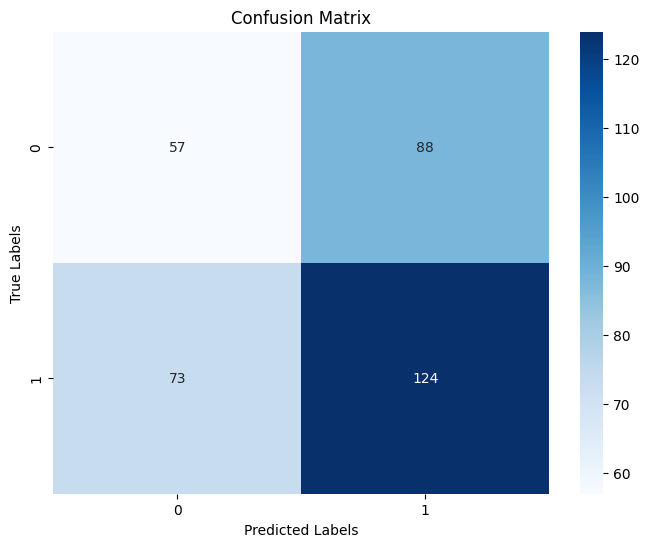

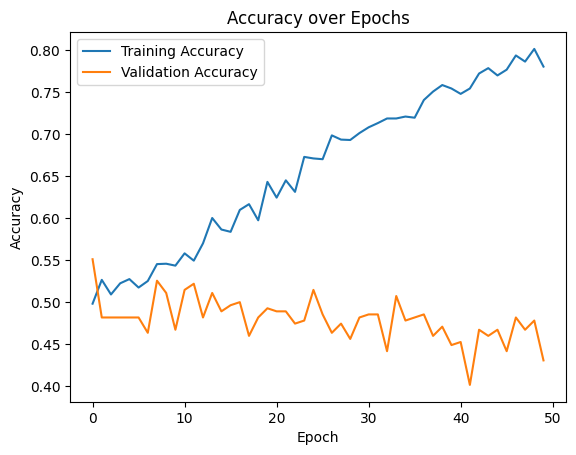

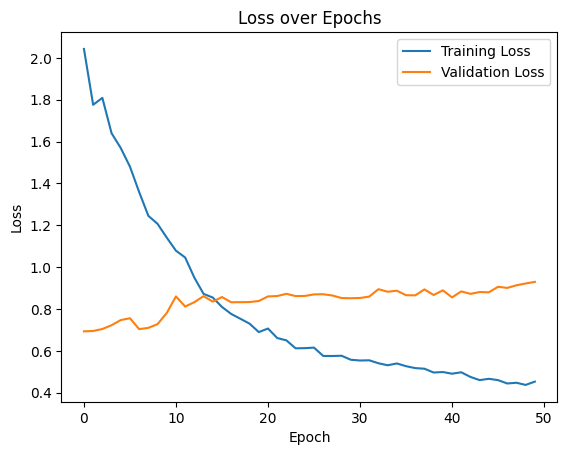

In [ ]:
test_loss, test_accuracy = shuffle_model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Modelin tahminlerini al
y_pred = shuffle_model.predict(X_test)
y_pred = (y_pred > 0.5)  # Sınıfları binary hale getir

# Confusion Matrix'i hesapla
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix'i görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# large Modeli eğitirken history almamışız
# Accuracy grafiğini çizdir
plt.plot(shuffle_history.history['accuracy'], label='Training Accuracy')
plt.plot(shuffle_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

# Loss grafiğini çizdir
plt.plot(shuffle_history.history['loss'], label='Training Loss')
plt.plot(shuffle_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Modeli kaydetmek
shuffle_model.save('/content/gdrive/My Drive/shuffle_model_2.h5')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


NameError: name 'large_model' is not defined

squeeze_net

In [ ]:
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
#from keras.engine.topology import get_source_inputs
from keras.utils import get_file
#from keras.utils import layer_utils

sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"

# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3

    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


# Original SqueezeNet from paper.

def SqueezeNet(input_tensor=None, input_shape=None,
               weights='imagenet',
               classes=1000,
              use_bn_on_input = False, # to avoid preprocessing
               first_stride = 2
              ):
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=227,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                     require_flatten = False)

    if input_tensor is None:
        raw_img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if use_bn_on_input:
        img_input = BatchNormalization()(raw_img_input)
    else:
        img_input = raw_img_input


    x = Convolution2D(64, (3, 3), strides=(first_stride, first_stride), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    x = Dropout(0.5, name='drop9')(x)

    x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    out = Activation('softmax', name='loss')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = raw_img_input

    model = Model(inputs, out, name='squeezenet')

    # load weights
    if weights == 'imagenet':

        weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

In [ ]:
squeeeze = SqueezeNet(weights='imagenet',input_shape=(224,224,3))

"""for layer in squeeeze.layers[:50]:
    layer.trainable = False"""
squeeeze.summary()

Model: "squeezenet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 111, 111, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 relu_conv1 (Activation)     (None, 111, 111, 64)         0         ['conv1[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 55, 55, 64)           0         ['relu_conv1[0][0]']          
                                                                                         

In [ ]:
squeeze_model = keras.models.Sequential()
squeeze_model.add(squeeeze)
squeeze_model.add(keras.layers.Flatten())
squeeze_model.add(keras.layers.Dense(64, activation='relu'))
#squeeze_model.add(keras.layers.Dropout(0.2))
squeeze_model.add(keras.layers.Dense(1, activation='sigmoid'))

squeeze_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 squeezenet (Functional)     (None, 1000)              1235496   
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 64)                64064     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1299625 (4.96 MB)
Trainable params: 1299625 (4.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)


squeeze_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

squeeze_history = squeeze_model.fit(augmented_images, augmented_labels,
                    batch_size=32,
                    epochs=50,
                    validation_data=(X_val, y_val))

test_loss,test_accuracy = squeeze_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Epoch 1/50
69/69 [==============================] - 17s 91ms/step - loss: 0.6897 - accuracy: 0.5444 - val_loss: 0.6926 - val_accuracy: 0.5182
Epoch 2/50
69/69 [==============================] - 4s 56ms/step - loss: 0.6880 - accuracy: 0.5581 - val_loss: 0.6930 - val_accuracy: 0.5182
Epoch 3/50
69/69 [==============================] - 4s 57ms/step - loss: 0.6874 - accuracy: 0.5581 - val_loss: 0.6935 - val_accuracy: 0.5182
Epoch 4/50
69/69 [==============================] - 4s 57ms/step - loss: 0.6870 - accuracy: 0.5581 - val_loss: 0.6937 - val_accuracy: 0.5182
Epoch 5/50
69/69 [==============================] - 4s 57ms/step - loss: 0.6868 - accuracy: 0.5581 - val_loss: 0.6942 - val_accuracy: 0.5182
Epoch 6/50
69/69 [==============================] - 4s 57ms/step - loss: 0.6866 - accuracy: 0.5581 - val_loss: 0.6943 - val_accuracy: 0.5182
Epoch 7/50
69/69 [==============================] - 4s 57ms/step - loss: 0.6866 - accuracy: 0.5581 - val_loss: 0.6947 - val_accuracy: 0.5182
Epoch 8/50
6

11/11 [==============================] - 0s 24ms/step - loss: 0.6821 - accuracy: 0.5760
Test Loss: 0.6821392774581909
Test Accuracy: 0.5760233998298645
11/11 [==============================] - 0s 19ms/step


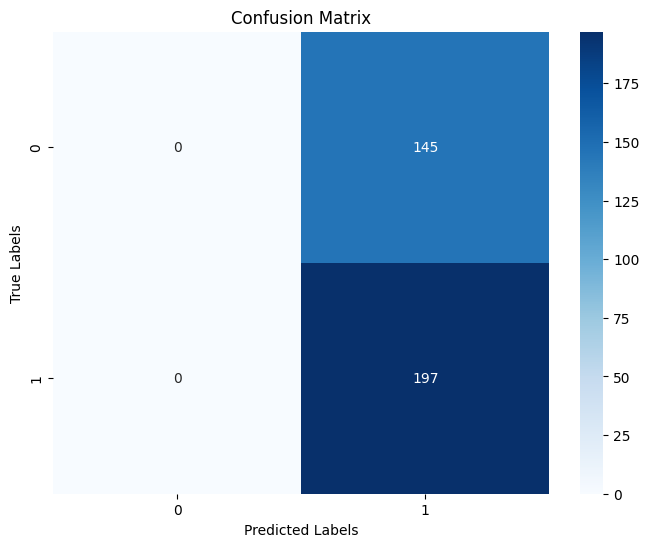

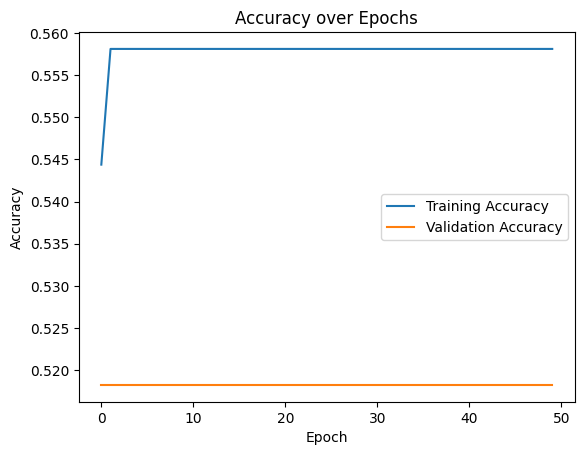

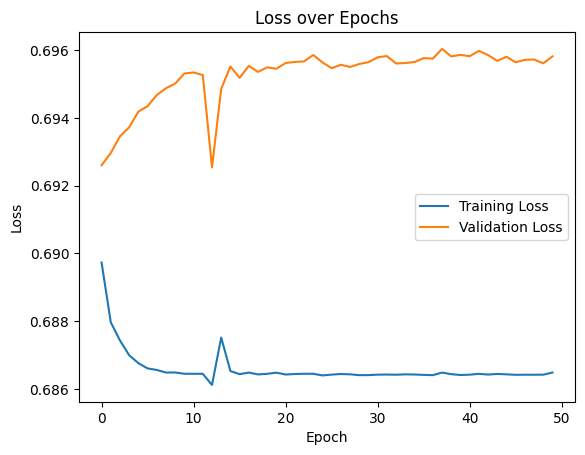

In [ ]:
test_loss, test_accuracy = squeeze_model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Modelin tahminlerini al
y_pred = squeeze_model.predict(X_test)
y_pred = (y_pred > 0.5)  # Sınıfları binary hale getir

# Confusion Matrix'i hesapla
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix'i görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# large Modeli eğitirken history almamışız
# Accuracy grafiğini çizdir
plt.plot(squeeze_history.history['accuracy'], label='Training Accuracy')
plt.plot(squeeze_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

# Loss grafiğini çizdir
plt.plot(squeeze_history.history['loss'], label='Training Loss')
plt.plot(squeeze_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Modeli kaydetmek
squeeze_model.save('/content/gdrive/My Drive/squeeze_model_2.h5')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Model Birleştirme

shufflenet ve mobilenetsmall

In [ ]:
shuffle_loaded_model = keras.models.load_model('/content/gdrive/My Drive/shuffle_model_2.h5')
small_loaded_model = keras.models.load_model('/content/gdrive/My Drive/small_model_2.h5')

In [ ]:
from keras.layers import Concatenate


for layer in shuffle_loaded_model.layers:
    layer._name = f'shuffle_{layer.name}'  # Adding a prefix to differentiate layers

for layer in small_loaded_model.layers:
    layer._name = f'small_{layer.name}'  # Adding a prefix to differentiate layers


output = Concatenate()([keras.layers.Flatten()(shuffle_loaded_model.output), keras.layers.Flatten()(small_loaded_model.output)])

output = keras.layers.Dropout(0.8)(output)
output = keras.layers.Dense(1, activation='sigmoid')(output)

concat_model = Model(inputs = [shuffle_loaded_model.input, small_loaded_model.input], outputs = output)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001)
concat_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
concat_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 MobilenetV3small_input (In  [(None, 224, 224, 3)]        0         []                            
 putLayer)                                                                                        
                                                                                                  
 MobilenetV3large_input (In  [(None, 224, 224, 3)]        0         []                            
 putLayer)                                                                                        
                                                                                                  
 small_MobilenetV3small (Fu  (None, 7, 7, 576)            939120    ['MobilenetV3small_input[0][0]
 nctional)                                                          ']                      

In [ ]:
concat_history = concat_model.fit([augmented_images, augmented_images], augmented_labels,
                    batch_size=32,
                    epochs=50,
                    validation_data=([X_val, X_val], y_val))

test_loss,test_accuracy = concat_model.evaluate([X_test, X_test], y_test, verbose=0)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Epoch 1/50
69/69 [==============================] - 10s 142ms/step - loss: 0.6987 - accuracy: 0.5215 - val_loss: 0.6950 - val_accuracy: 0.5036
Epoch 2/50
69/69 [==============================] - 7s 96ms/step - loss: 0.7031 - accuracy: 0.5174 - val_loss: 0.6938 - val_accuracy: 0.5036
Epoch 3/50
69/69 [==============================] - 7s 98ms/step - loss: 0.7037 - accuracy: 0.5270 - val_loss: 0.6930 - val_accuracy: 0.5036
Epoch 4/50
69/69 [==============================] - 7s 97ms/step - loss: 0.6989 - accuracy: 0.5261 - val_loss: 0.6925 - val_accuracy: 0.5036
Epoch 5/50
69/69 [==============================] - 7s 95ms/step - loss: 0.6984 - accuracy: 0.5320 - val_loss: 0.6929 - val_accuracy: 0.5036
Epoch 6/50
69/69 [==============================] - 7s 95ms/step - loss: 0.6980 - accuracy: 0.5270 - val_loss: 0.6924 - val_accuracy: 0.5036
Epoch 7/50
69/69 [==============================] - 6s 94ms/step - loss: 0.7054 - accuracy: 0.5288 - val_loss: 0.6923 - val_accuracy: 0.5073
Epoch 8/50


11/11 [==============================] - 1s 58ms/step - loss: 0.6825 - accuracy: 0.5760
Test Loss: 0.6825050711631775
Test Accuracy: 0.5760233998298645
11/11 [==============================] - 2s 55ms/step


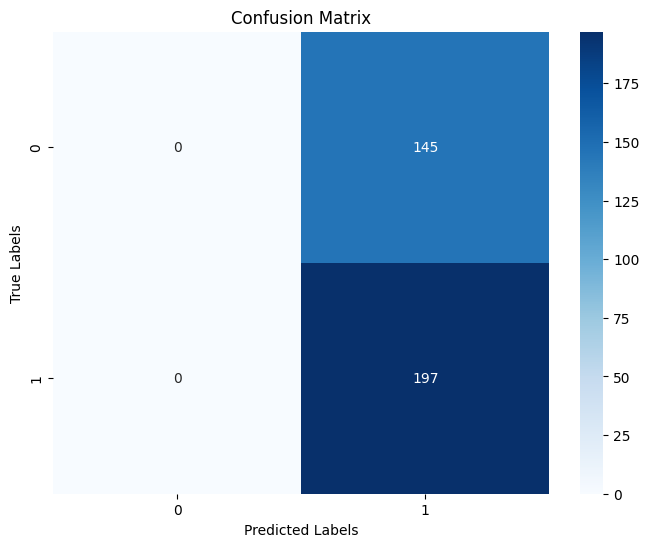

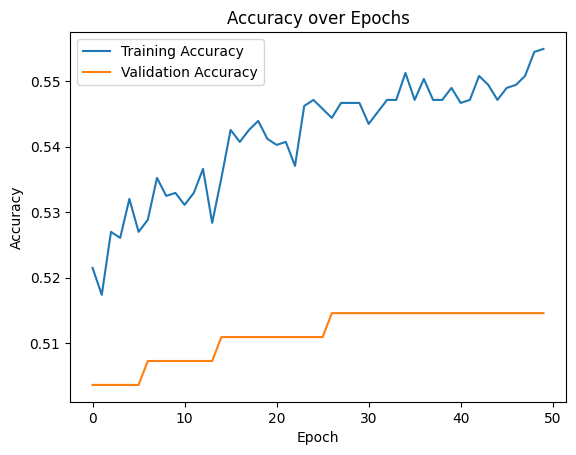

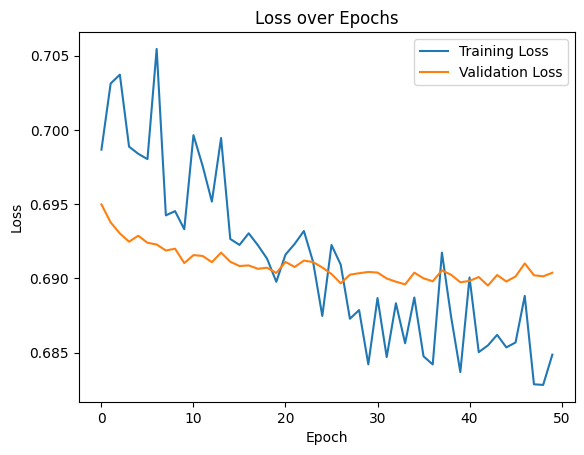

In [ ]:
test_loss, test_accuracy = concat_model.evaluate([X_test, X_test], y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Modelin tahminlerini al
y_pred = concat_model.predict([X_test,X_test])
y_pred = (y_pred > 0.5)  # Sınıfları binary hale getir

# Confusion Matrix'i hesapla
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix'i görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# large Modeli eğitirken history almamışız
# Accuracy grafiğini çizdir
plt.plot(concat_history.history['accuracy'], label='Training Accuracy')
plt.plot(concat_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

# Loss grafiğini çizdir
plt.plot(concat_history.history['loss'], label='Training Loss')
plt.plot(concat_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()